In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def load_and_clean_data():
    df_gold = pd.read_csv('Gold Price (2013-2023).csv')
    df_gold['Date'] = pd.to_datetime(df_gold['Date'])
    for col in ['Price', 'Open', 'High', 'Low']:
        df_gold[col] = df_gold[col].astype(str).str.replace(',', '').astype(float)
    df_gold = df_gold.sort_values('Date').set_index('Date')

    df_market = pd.read_csv('final_data.csv')
    df_market['Date'] = pd.to_datetime(df_market['Date'], dayfirst=True)
    for col in ['USO', 'SLV', 'S&P500', 'EUR/USD']:
        if df_market[col].dtype == 'object':
            df_market[col] = df_market[col].astype(str).str.replace(',', '').astype(float)
    df_market = df_market.sort_values('Date').set_index('Date')

    df_fed = pd.read_csv('FEDFUNDS.csv')
    df_fed['Date'] = pd.to_datetime(df_fed['observation_date'])
    df_fed = df_fed.set_index('Date')[['FEDFUNDS']]

    df_cpi = pd.read_csv('CORESTICKM159SFRBATL.csv')
    df_cpi['Date'] = pd.to_datetime(df_cpi['observation_date'])
    df_cpi = df_cpi.set_index('Date')[['CORESTICKM159SFRBATL']]
    
    return df_gold, df_market, df_fed, df_cpi

df_gold, df_market, df_fed, df_cpi = load_and_clean_data()

In [3]:
full_idx = pd.date_range(start=df_gold.index.min(), end=df_gold.index.max(), freq='D')
df_fed_daily = df_fed.reindex(full_idx, method='ffill')
df_cpi_daily = df_cpi.reindex(full_idx, method='ffill')

df = df_gold.join([df_market, df_fed_daily, df_cpi_daily], how='inner')

df['Real_Rate'] = df['FEDFUNDS'] - df['CORESTICKM159SFRBATL']
target_col = 'Price'
features_to_log = ['Price', 'S&P500', 'SLV', 'USO', 'EUR/USD']

for col in features_to_log:
    df[f'{col}_LogRet'] = np.log(df[col] / df[col].shift(1))

df = df.dropna()

feature_cols = [
    'Price_LogRet',        
    'S&P500_LogRet',  
    'SLV_LogRet',     
    'USO_LogRet',
    'EUR/USD',     
    'Real_Rate'   
]

data = df[feature_cols].values



In [4]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
def create_dataset_multi(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step, :])
        Y.append(dataset[i+time_step, :])  # ALL FEATURES
    return np.array(X), np.array(Y)

time_step = 60
X, y = create_dataset_multi(data_scaled, time_step)

train_size = int(len(X) * 0.9)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [6]:
n_features = X.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True,
         input_shape=(time_step, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(n_features)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/150


d:\Project 1\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0522 - val_loss: 0.0087
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0191 - val_loss: 0.0052
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0153 - val_loss: 0.0033
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0131 - val_loss: 0.0029
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0125 - val_loss: 0.0028
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0111 - val_loss: 0.0028
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0103 - val_loss: 0.0030
Epoch 8/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0094 - val_loss: 0.0026
Epoch 9/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0088 - val_loss: 0.0025
Epoch 10/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0083 - val_loss: 0.0028
Epoch 11/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 12/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

In [7]:
n_test = len(X_test)

current_window = X_train[-1].copy()
recursive_preds = []

for _ in range(n_test):
    pred = model.predict(
        current_window.reshape(1, time_step, n_features),
        verbose=0
    )[0]

    recursive_preds.append(pred)

    current_window = np.vstack([
        current_window[1:],
        pred
    ])

recursive_preds = np.array(recursive_preds)


In [8]:
y_test_real = scaler.inverse_transform(y_test)
pred_real = scaler.inverse_transform(recursive_preds)

last_train_price = df['Price'].iloc[train_size + time_step]

price_preds = []
price_actual = []

price_hat = last_train_price
price_true = last_train_price

for i in range(len(pred_real)):
    # predicted return
    price_hat *= np.exp(pred_real[i, 0])
    price_preds.append(price_hat)

    # true return
    price_true *= np.exp(y_test_real[i, 0])
    price_actual.append(price_true)


In [9]:
mape = mean_absolute_percentage_error(price_actual, price_preds)
print(f"MAPE (Full Recursive - All Features): {mape*100:.2f}%")



MAPE (Full Recursive - All Features): 16.74%


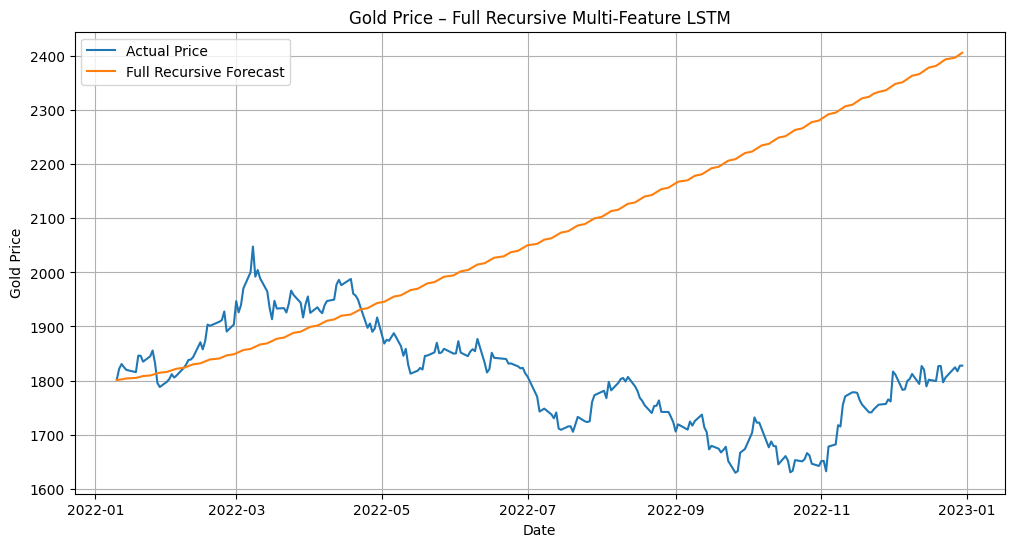

In [10]:
dates_test = df.index[-len(price_actual):]

plt.figure(figsize=(12,6))
plt.plot(dates_test, price_actual, label='Actual Price')
plt.plot(dates_test, price_preds, label='Full Recursive Forecast')
plt.title('Gold Price – Full Recursive Multi-Feature LSTM')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()
